In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../scripts/')

from equiv_test_funcs import *

In [3]:
def ttests(df):
    
    # run t tests from script (should be what's done in perform tests)

    if norm:
      # normalize each row (sample) by the number of counts
        df = normalize(df)

    if log_scale:
        df = log2_scale(df)

    plot = False

    # testing out function you can use in Python code
    # perform_tests_for_df(df, args.delta)

    out_df = loop_over_genes(df, delta, plot)

    out_df = process_out_df(out_df, delta)
    #display(out_df.head())
    return out_df["sig_diff"][0], out_df["sig_equiv"][0]


## Simulation description

2 populations (two different kinds of cell types)

There are only two genes (gene A and gene B)

We're taking `num_samples` samples from each population

Population 1/"cell type":
sample 1
sample 2 
sample 3

Population 2/"cell type":
sample 4
sample 5
sample 6

We're going to define the fraction of gene expression that is from gene A for each population

`geneA_fracs`: it's a list of length 2. The first entry is the fraction of gene A in population 1. The second entry entry is the fraction of gene A in population 2.

For example, if `geneA_fracs = [0.2, 0.8]` it means 20% of the gene expression is from gene A in population 1. So we might expect to have 22 counts from gene A and 83 counts from gene B in a sample from population 1.

For the second population, we might expect something like 79 counts from gene A and 18 from gene B.

The `numReads` list contains all the values of read numbers we want to test for. What I mean by read number: the number of "counts" we have for a given sample.

Additional parameters: when `norm = True` we normalize the scores just by dividing by the total number of reads. When `log_scale = True` we take the log of the count values.

`delta`: this is the equivalence testing parameter. When ` log_scale = True`, `delta = 1` tests for fold change.

In [4]:
outpath = "../plots/"
numReads = [5, 10, 50, 100, 500, 1000]

numReads = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]

num_trials = 10

num_samples = 3

#geneA_fracs = [0.3, 0.6]

#geneA_fracs = [0.2, 0.8]

#geneA_fracs = [0.45, 0.55]

#geneA_fracs = [0.1, 0.15]

#geneA_fracs = [0.01, 0.015]

geneA_fracs = [0.05, 0.1]

norm = True
log_scale = True

delta = 1
alpha = 0.05

In [5]:
np.random.seed(123)

out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
       "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
       "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

for num in numReads:
    print("num reads: {}".format(num))
    # collect p vals for each
    num_sig_diff = 0
    num_sig_equiv = 0
    num_inconclusive = 0
    
    for i in range(num_trials):
        data = {"sample" : [], "A" : [], "B" : [], "cell_type" : []}
        count = 0
        for j in range(len(geneA_fracs)):
            for k in range(num_samples):
                count += 1
                
                # add 1 so it's never zero
                n = np.random.poisson(num) + 1
                A = np.random.binomial(n, geneA_fracs[j])
                data["sample"].append("sample" + str(count))
                data["A"].append(A)
                data["B"].append(n - A)
                data["cell_type"].append(j)
        df = pd.DataFrame(data).set_index("sample")
        
        # get results
        diff_sig, equiv_sig = ttests(df)
        
        # save output
        num_sig_diff += diff_sig
        num_sig_equiv += equiv_sig
        num_inconclusive += 1 - diff_sig - equiv_sig
        
    # get frac significant
    out["numReads"].append(num)

#    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
    out["frac_sig_diff"].append(num_sig_diff/num_trials)
    out["frac_sig_diff_lower"].append(lower_ci)
    out["frac_sig_diff_upper"].append(upper_ci)

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
    out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
    out["frac_sig_equiv_lower"].append(lower_ci)
    out["frac_sig_equiv_upper"].append(upper_ci)
    

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
    out["frac_sig_inc"].append(num_inconclusive/num_trials)
    out["frac_sig_inc_lower"].append(lower_ci)
    out["frac_sig_inc_upper"].append(upper_ci)
out = pd.DataFrame(out)
display(out)

/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.333333
sample3    0.000000
sample4    0.000000
sample5    0.000000
sample6    0.000000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.666667
sample3    1.000000
sample4    1.000000
sample5    1.000000
sample6    1.000000
Name: B, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1]

num reads: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 369.69it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.0
sample2    0.0
sample3    0.0
sample4    0.0
sample5    0.0
sample6    0.0
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.0
sample2    1.0
sample3    1.0
sample4    1.0
sample5    1.0
sample6    1.0
Name: B, dtype: float64' has dtype incompatible with int6

  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 592.25it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of inc

num reads: 2


  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 556.35it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of inc

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 816.01it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.000000
sample3    0.000000
sample4    0.000000
sample5    0.000000
sample6    0.333333
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    1.000000
sample3    1.000000
sample4    1.000000
sample5    1.000000
sample6    0.6666

num reads: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 796.41it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.00
sample2    0.00
sample3    0.00
sample4    0.00
sample5    0.75
sample6    0.00
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.00
sample2    1.00
sample3    1.00
sample4    1.00
sample5    0.25
sample6    1.00
Name: B, dtype: float64' has dtype incompatib

  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 745.72it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of inc

num reads: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 737.72it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.2
sample2    0.5
sample3    0.0
sample4    0.0
sample5    0.0
sample6    0.0
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.8
sample2    0.5
sample3    1.0
sample4    1.0
sample5    1.0
sample6    1.0
Name: B, dtype: float64' has dtype incompatible with int6

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 893.17it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.00
sample2    0.00
sample3    0.00
sample4    0.00
sample5    0.00
sample6    0.25
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.00
sample2    1.00
sample3    1.00
sample4    1.00
sample5    1.00
sample6    0.75
Name: B, dtype: float64' has dtype incompatib

num reads: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 705.70it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.000000
sample3    0.000000
sample4    0.000000
sample5    0.000000
sample6    0.153846
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    1.000000
sample3    1.000000
sample4    1.000000
sample5    1.000000
sample6    0.8461

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 611.99it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.125000
sample3    0.125000
sample4    0.200000
sample5    0.000000
sample6    0.142857
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.875000
sample3    0.875000
sample4    0.800000
sample5    1.000000
sample6    0.8571

num reads: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 742.62it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.000000
sample3    0.058824
sample4    0.076923
sample5    0.250000
sample6    0.000000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    1.000000
sample3    0.941176
sample4    0.923077
sample5    0.750000
sample6    1.0000

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 761.63it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.111111
sample2    0.100000
sample3    0.125000
sample4    0.142857
sample5    0.125000
sample6    0.200000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.888889
sample2    0.900000
sample3    0.875000
sample4    0.857143
sample5    0.875000
sample6    0.8000

num reads: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 706.23it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.058824
sample2    0.000000
sample3    0.000000
sample4    0.055556
sample5    0.230769
sample6    0.153846
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.941176
sample2    1.000000
sample3    1.000000
sample4    0.944444
sample5    0.769231
sample6    0.8461

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 794.60it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.052632
sample3    0.083333
sample4    0.150000
sample5    0.142857
sample6    0.181818
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.947368
sample3    0.916667
sample4    0.850000
sample5    0.857143
sample6    0.8181

num reads: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 683.33it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.138889
sample2    0.000000
sample3    0.000000
sample4    0.125000
sample5    0.100000
sample6    0.260870
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.861111
sample2    1.000000
sample3    1.000000
sample4    0.875000
sample5    0.900000
sample6    0.7391

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 707.24it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.095238
sample2    0.000000
sample3    0.043478
sample4    0.130435
sample5    0.055556
sample6    0.107143
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.904762
sample2    1.000000
sample3    0.956522
sample4    0.869565
sample5    0.944444
sample6    0.8928

num reads: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 706.53it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.086957
sample2    0.157895
sample3    0.076923
sample4    0.047619
sample5    0.050000
sample6    0.121212
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.913043
sample2    0.842105
sample3    0.923077
sample4    0.952381
sample5    0.950000
sample6    0.8787

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 784.64it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.000000
sample3    0.000000
sample4    0.090909
sample5    0.043478
sample6    0.115385
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    1.000000
sample3    1.000000
sample4    0.909091
sample5    0.956522
sample6    0.8846

num reads: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 792.80it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.080000
sample2    0.083333
sample3    0.035714
sample4    0.083333
sample5    0.078947
sample6    0.125000
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.920000
sample2    0.916667
sample3    0.964286
sample4    0.916667
sample5    0.921053
sample6    0.8750

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 809.09it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.064516
sample3    0.057143
sample4    0.166667
sample5    0.037037
sample6    0.147059
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.935484
sample3    0.942857
sample4    0.833333
sample5    0.962963
sample6    0.8529

num reads: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 638.79it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.073171
sample2    0.032258
sample3    0.111111
sample4    0.105263
sample5    0.030303
sample6    0.161290
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.926829
sample2    0.967742
sample3    0.888889
sample4    0.894737
sample5    0.969697
sample6    0.8387

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 729.13it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.023256
sample2    0.042553
sample3    0.052632
sample4    0.076923
sample5    0.103448
sample6    0.128205
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.976744
sample2    0.957447
sample3    0.947368
sample4    0.923077
sample5    0.896552
sample6    0.8717

num reads: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 723.28it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.000000
sample2    0.076923
sample3    0.000000
sample4    0.125000
sample5    0.072727
sample6    0.096774
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    1.000000
sample2    0.923077
sample3    1.000000
sample4    0.875000
sample5    0.927273
sample6    0.9032

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 705.52it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.045455
sample2    0.000000
sample3    0.098039
sample4    0.020408
sample5    0.130435
sample6    0.139535
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.954545
sample2    1.000000
sample3    0.901961
sample4    0.979592
sample5    0.869565
sample6    0.8604

num reads: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 852.93it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.055556
sample2    0.061224
sample3    0.064516
sample4    0.139535
sample5    0.078947
sample6    0.145455
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.944444
sample2    0.938776
sample3    0.935484
sample4    0.860465
sample5    0.921053
sample6    0.8545

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.89it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.050847
sample2    0.038462
sample3    0.068966
sample4    0.060000
sample5    0.088889
sample6    0.108108
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.949153
sample2    0.961538
sample3    0.931034
sample4    0.940000
sample5    0.911111
sample6    0.8918

num reads: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 873.72it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.040000
sample2    0.075472
sample3    0.028169
sample4    0.063830
sample5    0.127660
sample6    0.089552
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.960000
sample2    0.924528
sample3    0.971831
sample4    0.936170
sample5    0.872340
sample6    0.9104

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 794.90it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.016129
sample2    0.018868
sample3    0.065217
sample4    0.092593
sample5    0.080000
sample6    0.102041
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.983871
sample2    0.981132
sample3    0.934783
sample4    0.907407
sample5    0.920000
sample6    0.8979

num reads: 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 711.68it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.061728
sample2    0.078652
sample3    0.066667
sample4    0.111111
sample5    0.062500
sample6    0.123894
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.938272
sample2    0.921348
sample3    0.933333
sample4    0.888889
sample5    0.937500
sample6    0.8761

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 707.24it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.048544
sample2    0.051282
sample3    0.075269
sample4    0.113208
sample5    0.115789
sample6    0.129630
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.951456
sample2    0.948718
sample3    0.924731
sample4    0.886792
sample5    0.884211
sample6    0.8703

num reads: 150


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 784.28it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.077419
sample2    0.037879
sample3    0.043478
sample4    0.088435
sample5    0.107595
sample6    0.116438
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.922581
sample2    0.962121
sample3    0.956522
sample4    0.911565
sample5    0.892405
sample6    0.8835

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 676.83it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.039474
sample2    0.070922
sample3    0.020000
sample4    0.109677
sample5    0.075188
sample6    0.121019
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.960526
sample2    0.929078
sample3    0.980000
sample4    0.890323
sample5    0.924812
sample6    0.8789

num reads: 200


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 677.98it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.056410
sample2    0.045249
sample3    0.009434
sample4    0.095694
sample5    0.069444
sample6    0.055556
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.943590
sample2    0.954751
sample3    0.990566
sample4    0.904306
sample5    0.930556
sample6    0.9444

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 890.79it/s]
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.068966
sample2    0.087156
sample3    0.051948
sample4    0.086758
sample5    0.134328
sample6    0.113402
Name: A, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:,:-1] = df.iloc[:,:-1].div(df.iloc[:,:-1].sum(axis=1), axis=0)
/Users/jolivie1/Desktop/Research/equivalence_testing/notebooks/../scripts/equiv_test_funcs.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'sample
sample1    0.931034
sample2    0.912844
sample3    0.948052
sample4    0.913242
sample5    0.865672
sample6    0.8865

,numReads,frac_sig_diff,frac_sig_diff_lower,frac_sig_diff_upper,frac_sig_equiv,frac_sig_equiv_lower,frac_sig_equiv_upper,frac_sig_inc,frac_sig_inc_lower,frac_sig_inc_upper
0,1,0.0,0.000000,0.000000,0.7,0.415974,0.984026,0.3,0.015974,0.584026
1,2,0.0,0.000000,0.000000,0.3,0.015974,0.584026,0.7,0.415974,0.984026
2,3,0.0,0.000000,0.000000,0.4,0.096364,0.703636,0.6,0.296364,0.903636
3,4,0.0,0.000000,0.000000,0.2,0.000000,0.447918,0.8,0.552082,1.000000
4,5,0.0,0.000000,0.000000,0.1,0.000000,0.285939,0.9,0.714061,1.000000
5,10,0.0,0.000000,0.000000,0.1,0.000000,0.285939,0.9,0.714061,1.000000
6,15,0.1,0.000000,0.285939,0.0,0.000000,0.000000,0.9,0.714061,1.000000
7,20,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.000000
8,25,0.1,0.000000,0.285939,0.0,0.000000,0.000000,0.9,0.714061,1.000000
9,30,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.000000


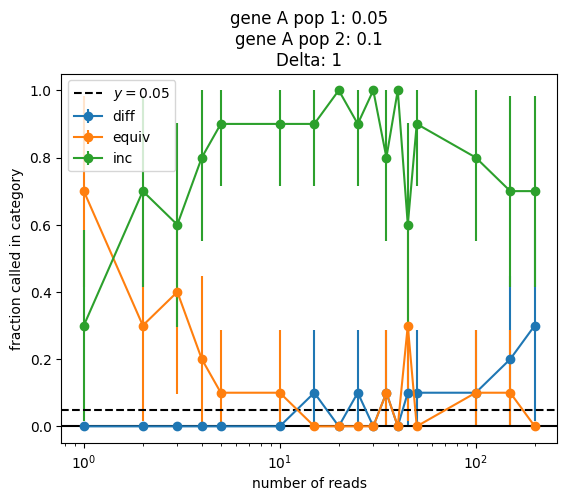

In [6]:
plt.errorbar(out["numReads"], out["frac_sig_diff"], yerr = [out["frac_sig_diff"] - out["frac_sig_diff_lower"],
            out["frac_sig_diff_upper"] - out["frac_sig_diff"] ], marker = "o", label = "diff")
plt.errorbar(out["numReads"], out["frac_sig_equiv"], yerr = [out["frac_sig_equiv"] - out["frac_sig_equiv_lower"],
            out["frac_sig_equiv_upper"] - out["frac_sig_equiv"] ], marker = "o", label = "equiv")
plt.errorbar(out["numReads"], out["frac_sig_inc"], yerr = [out["frac_sig_inc"] - out["frac_sig_inc_lower"],
            out["frac_sig_inc_upper"] - out["frac_sig_inc"] ], marker = "o", label = "inc")
plt.xscale("log")
plt.axhline(y=0.05, linestyle="--", color="k", label = "$y = 0.05$")
plt.axhline(y=0.0, color="k")

plt.legend()
plt.xlabel("number of reads")
plt.ylabel("fraction called in category")
plt.title("gene A pop 1: {}\ngene A pop 2: {}\nDelta: {}".format(geneA_fracs[0], geneA_fracs[1], delta))
plt.savefig("{}pop1_{}_pop2_{}_delt_{}.png".format(outpath, *geneA_fracs, delta),bbox_inches='tight')
plt.show()